## Configuration Details

In [1]:
from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

VERSION:  3.7.3


In [2]:
# data science standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from matplotlib.pyplot import figure
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# keras/tensorflow
from tensorflow.metrics import auc as tf_auc
from tensorflow import local_variables_initializer
import keras
import keras.backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Conv2D, \
        MaxPooling1D, LSTM, Flatten, BatchNormalization,Embedding,Reshape, Dropout


# Local custom data loading functions
import load_data
import clean_data
import custom_feature_extraction
import custom_keras_metrics

/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

### Load annoations

In [4]:
annotations ='../data/Annotations04-09-19.json'
df = load_data.getJSONData(annotations)

to  = 'label'
field = 'annotation'
df[to] = df.apply(lambda row:clean_data.convertAnnotationtoBinary(row, field), axis =1)   
df.head()

,annotation,fileID,text,label
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,0
1,permission_statement,1,i give my permission for photographs/audio/vid...,1
2,NON_permission_statement.,1,language for required recordings: the research...,0
3,NON_permission_statement.,1,"""(if applicable, add) information about indivi...",0
4,NON_permission_statement.,1,this consent form will be filed securely in an...,0


### Sentence Lengths

In [5]:
df['sent_len'] = df['text'].apply(len)

print('mean sentence length:', df['sent_len'].mean())
print('std sentence length:', df['sent_len'].std())
print('max sentence length:', df['sent_len'].max())
print('min sentence length:', df['sent_len'].min())

mean sentence length: 160.88580168238593
std sentence length: 114.46874256211423
max sentence length: 1961
min sentence length: 7


### Unique Words

In [6]:
uniques = set()
df['text'].str.lower().str.split().apply(uniques.update)

print(len(uniques))

10360


### Data Pre-processing

In [7]:
slim2 = df[['label', 'text']] # subset dataframe to make it easier to work with

# TODO: Functionalize

In [8]:
vocabulary_size = 8000
maxlen = 400

tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(slim2['text'])
sequences = tokenizer.texts_to_sequences(slim2['text'])
data = pad_sequences(sequences, maxlen=maxlen)

In [9]:
slim2['data'] = data.tolist()
# slim2['data'].head(10)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
new_col_names = ['seq_posi' + str(i) for i in range(0,maxlen)]
pos_seq_df = pd.DataFrame(slim2['data'].values.tolist(), columns=new_col_names)
slim2 = pd.concat([slim2, pos_seq_df], axis=1)
# slim2.head()

### Train-Test Split


In [11]:
text_train, text_test = train_test_split(slim2,
                               stratify=slim2['label'],
                               test_size=0.3, 
                               random_state=1729)

### Convert Labels to Categorical

In [12]:
label_train = keras.utils.to_categorical(text_train['label'], num_classes=2)
label_test = keras.utils.to_categorical(text_test['label'], num_classes=2)

## Baseline Models

In [13]:
models = []

dtBase = DecisionTreeClassifier(max_depth=10, 
                               max_features=9,
                               class_weight={1:.2})

models.append(("DecisionTree",dtBase))

rdfBase = RandomForestClassifier(n_estimators=1000,
                                class_weight={1:.2})

models.append(("RandomForest",rdfBase))

models.append(("SVM",SVC(gamma='auto')))
models.append(("LogisticRegression", LogisticRegression(solver='liblinear',
                                  max_iter=1000,
                                  penalty='l1')))


In [14]:
fitted_models = []
new_rows = []

for name, model in models:
    model.fit(text_train[new_col_names], text_train['label'])
    fitted_models.append((name, model))
    prediction_vec = model.predict(text_test[new_col_names])
    row = {
        'Model:': name,
        'Accuracy:': accuracy_score(text_test['label'], prediction_vec),
        'Precision:': precision_score(text_test['label'], prediction_vec),
        'ROC:': roc_auc_score(text_test['label'], prediction_vec)
    }
    
    new_rows.append(row)

baseline_results_df = pd.DataFrame(new_rows)

In [15]:
# Naive baseline
majority_class = np.zeros(len(text_test['label']))

count = len(baseline_results_df)

ac = accuracy_score(text_test['label'], majority_class)
pr = precision_score(text_test['label'], majority_class)
roc = roc_auc_score(text_test['label'], majority_class)

baseline_results_df.loc[count, 'Model:'] = 'Naive Majority Class Classifier'
baseline_results_df.loc[count, 'Accuracy:'] = ac
baseline_results_df.loc[count, 'Precision:'] = pr
baseline_results_df.loc[count, 'ROC:'] = roc

cols = ['Model:', 'Accuracy:', 'Precision:', 'ROC:']

baseline_results_df = baseline_results_df[cols]
baseline_results_df.head(len(baseline_results_df))

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Model:,Accuracy:,Precision:,ROC:
0,DecisionTree,0.769754,0.285714,0.503254
1,RandomForest,0.791844,0.707317,0.548786
2,SVM,0.796092,0.866667,0.547433
3,LogisticRegression,0.768054,0.296296,0.504885
4,Naive Majority Class Classifier,0.777400,0.000000,0.500000


## Shared Hyperparameters

In [16]:
n_epochs = 5
to_shuffle = True
n_batch = 3

## CNN-LTSM (Model 1)

In [17]:
cnn_1 = Sequential()
cnn_1.add(Embedding(vocabulary_size, 100, input_length=maxlen))
cnn_1.add(Dropout(0.2))
cnn_1.add(Conv1D(64, 5, activation='relu'))
cnn_1.add(MaxPooling1D(pool_size=4))
cnn_1.add(LSTM(100))
cnn_1.add(Dense(2, activation='softmax'))
cnn_1.compile(loss='binary_crossentropy', 
               optimizer='adam', 
                metrics=['accuracy', 
                    custom_keras_metrics.keras_precision, 
                    custom_keras_metrics.keras_recall, 
                    custom_keras_metrics.keras_auc])

fit_cnn_1 = cnn_1.fit(text_train[new_col_names], 
                  label_train, 
                  validation_data=(text_test[new_col_names],label_test), 
                  epochs=n_epochs,
                  shuffle=to_shuffle,
                  batch_size=3)
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.
Train on 2746 samples, validate on 1177 samples
Epoch 1/5
2746/2746 [==============================] - 104s 38ms/step - loss: 0.4101 - acc: 0.8274 - keras_precision: 0.8274 - keras_recall: 0.8274 - keras_auc: 0.8643 - val_loss: 0.3405 - val_acc: 0.8564 - val_keras_precision: 0.8564 - val_keras_recall: 0.8564 - val_keras_auc: 0.9030
Epoch 2/5
2746/2746 [==============================] - 107s 39ms/step - loss: 0.2276 - acc: 0.9104 - keras_precision: 0.9104 - keras_recall: 0.9104 - keras_auc: 0.9255 - val_loss: 0.3306 - val_acc: 0.8641 - val_keras_precision: 0.8641 - val_keras_recall: 0.8641 - val_keras_auc: 0.9363
Epoch 3/5
2746/2746

## CNN 2 - Without LSTM

In [18]:
cnn_2 = Sequential()
cnn_2.add(Embedding(vocabulary_size, 100, input_length=maxlen))
cnn_2.add(Dropout(0.2))
cnn_2.add(Conv1D(64, 5, activation='relu'))
cnn_2.add(MaxPooling1D(pool_size=4))
cnn_2.add(Flatten())
cnn_2.add(Dense(2, activation='softmax'))
cnn_2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
                metrics=['accuracy', 
                    custom_keras_metrics.keras_precision, 
                    custom_keras_metrics.keras_recall, 
                    custom_keras_metrics.keras_auc])

fit_cnn_2 = cnn_2.fit(text_train[new_col_names], 
                  label_train, 
                  validation_data=(text_test[new_col_names],label_test), 
                  epochs=n_epochs,
                  shuffle=to_shuffle,
                  batch_size=n_batch)

Train on 2746 samples, validate on 1177 samples
Epoch 1/5
2746/2746 [==============================] - 12s 5ms/step - loss: 0.4350 - acc: 0.8132 - keras_precision: 0.8132 - keras_recall: 0.8132 - keras_auc: 0.8045 - val_loss: 0.3464 - val_acc: 0.8624 - val_keras_precision: 0.8624 - val_keras_recall: 0.8624 - val_keras_auc: 0.8893
Epoch 2/5
2746/2746 [==============================] - 12s 4ms/step - loss: 0.2163 - acc: 0.9159 - keras_precision: 0.9159 - keras_recall: 0.9159 - keras_auc: 0.9184 - val_loss: 0.3816 - val_acc: 0.8649 - val_keras_precision: 0.8649 - val_keras_recall: 0.8649 - val_keras_auc: 0.9331
Epoch 3/5
2746/2746 [==============================] - 13s 5ms/step - loss: 0.0914 - acc: 0.9643 - keras_precision: 0.9643 - keras_recall: 0.9643 - keras_auc: 0.9448 - val_loss: 0.4398 - val_acc: 0.8641 - val_keras_precision: 0.8641 - val_keras_recall: 0.8641 - val_keras_auc: 0.9531
Epoch 4/5
2746/2746 [==============================] - 13s 5ms/step - loss: 0.0460 - acc: 0.9880 - k

## CNN 3 - LSTM without Convolution

In [19]:
cnn_3 = Sequential()
cnn_3.add(Embedding(vocabulary_size, 100, input_length=maxlen))
cnn_3.add(Dropout(0.2))
cnn_3.add(LSTM(100))
cnn_3.add(Dense(2, activation='softmax'))
cnn_3.compile(loss='binary_crossentropy', 
               optimizer='adam', 
                metrics=['accuracy', 
                    custom_keras_metrics.keras_precision, 
                    custom_keras_metrics.keras_recall, 
                    custom_keras_metrics.keras_auc])

fit_cnn_3 = cnn_3.fit(text_train[new_col_names], 
                  label_train, 
                  validation_data=(text_test[new_col_names],label_test), 
                  epochs=n_epochs,
                  shuffle=to_shuffle,
                  batch_size=n_batch)

Train on 2746 samples, validate on 1177 samples
Epoch 1/5
2746/2746 [==============================] - 368s 134ms/step - loss: 0.4322 - acc: 0.8157 - keras_precision: 0.8157 - keras_recall: 0.8157 - keras_auc: 0.8367 - val_loss: 0.3502 - val_acc: 0.8513 - val_keras_precision: 0.8513 - val_keras_recall: 0.8513 - val_keras_auc: 0.8908
Epoch 2/5
2746/2746 [==============================] - 354s 129ms/step - loss: 0.2498 - acc: 0.9024 - keras_precision: 0.9024 - keras_recall: 0.9024 - keras_auc: 0.9165 - val_loss: 0.3299 - val_acc: 0.8615 - val_keras_precision: 0.8615 - val_keras_recall: 0.8615 - val_keras_auc: 0.9281
Epoch 3/5
2746/2746 [==============================] - 364s 133ms/step - loss: 0.1642 - acc: 0.9385 - keras_precision: 0.9385 - keras_recall: 0.9385 - keras_auc: 0.9393 - val_loss: 0.4084 - val_acc: 0.8352 - val_keras_precision: 0.8352 - val_keras_recall: 0.8352 - val_keras_auc: 0.9447
Epoch 4/5
2746/2746 [==============================] - 427s 155ms/step - loss: 0.1080 - acc

## Autoencoder

In [20]:
dim = text_train[new_col_names].shape[1]

auto_encoder_1 = Sequential()
auto_encoder_1.add(Dense(units=100, activation='relu', input_dim=dim))
auto_encoder_1.add(Dense(units=500, activation='softmax'))
auto_encoder_1.add(Dense(units=10, activation='softmax'))
auto_encoder_1.add(Dense(units=1000, activation='relu'))
auto_encoder_1.add(Dense(units=500, activation='relu'))
auto_encoder_1.add(Dense(units=2, activation='softmax'))

auto_encoder_1.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adagrad(lr=0.001), 
              metrics=['accuracy', 
                       custom_keras_metrics.keras_precision, 
                       custom_keras_metrics.keras_recall, 
                       custom_keras_metrics.keras_auc])

fit_auto_encoder_1 = auto_encoder_1.fit(text_train[new_col_names], 
                  label_train, 
                  validation_data=(text_test[new_col_names],label_test), 
                epochs=n_epochs,
                batch_size=n_batch,
                shuffle=to_shuffle)

Train on 2746 samples, validate on 1177 samples
Epoch 1/5
2746/2746 [==============================] - 7s 3ms/step - loss: 0.5335 - acc: 0.7771 - keras_precision: 0.7771 - keras_recall: 0.7771 - keras_auc: 0.7791 - val_loss: 0.5310 - val_acc: 0.7774 - val_keras_precision: 0.7774 - val_keras_recall: 0.7774 - val_keras_auc: 0.7763
Epoch 2/5
2746/2746 [==============================] - 7s 2ms/step - loss: 0.5306 - acc: 0.7775 - keras_precision: 0.7775 - keras_recall: 0.7775 - keras_auc: 0.7770 - val_loss: 0.5301 - val_acc: 0.7774 - val_keras_precision: 0.7774 - val_keras_recall: 0.7774 - val_keras_auc: 0.7774
Epoch 3/5
2746/2746 [==============================] - 6s 2ms/step - loss: 0.5305 - acc: 0.7775 - keras_precision: 0.7775 - keras_recall: 0.7775 - keras_auc: 0.7776 - val_loss: 0.5302 - val_acc: 0.7774 - val_keras_precision: 0.7774 - val_keras_recall: 0.7774 - val_keras_auc: 0.7774
Epoch 4/5
2746/2746 [==============================] - 6s 2ms/step - loss: 0.5303 - acc: 0.7775 - keras

In [21]:
cnn_1.name = "cnn_1"
cnn_2.name = "cnn_2"
cnn_3.name = "cnn_3"
auto_encoder_1.name = "auto_encoder_1"
ann_models = [cnn_1, cnn_2, cnn_3, auto_encoder_1]

In [22]:
# for model in ann_models:
#     print("##########################", model.name, "##########################")
#     print(model.summary())

## Results Table 

In [23]:
new_rows = []

for model in ann_models:  
    row = {"Model:": model.name, 
           "Precision:": model.history.history['val_keras_precision'][-1],
           "Accuracy:": model.history.history['val_acc'][-1],
           "ROC:": model.history.history['val_keras_auc'][-1],}
        
    new_rows.append(row) 
        
ann_results_df = pd.DataFrame(new_rows)
ann_results_df.head(len(ann_results_df))

,Accuracy:,Model:,Precision:,ROC:
0,0.855565,cnn_1,0.855565,0.966133
1,0.842821,cnn_2,0.842821,0.966807
2,0.831776,cnn_3,0.831776,0.958410
3,0.777400,auto_encoder_1,0.777400,0.777025


In [24]:
results_df = pd.concat([baseline_results_df, ann_results_df])
cols = ['Model:', 'Accuracy:', 'Precision:', 'ROC:']
results_df = results_df[cols]
results_df.head(len(results_df))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Model:,Accuracy:,Precision:,ROC:
0,DecisionTree,0.769754,0.285714,0.503254
1,RandomForest,0.791844,0.707317,0.548786
2,SVM,0.796092,0.866667,0.547433
3,LogisticRegression,0.768054,0.296296,0.504885
4,Naive Majority Class Classifier,0.777400,0.000000,0.500000
0,cnn_1,0.855565,0.855565,0.966133
1,cnn_2,0.842821,0.842821,0.966807
2,cnn_3,0.831776,0.831776,0.958410
3,auto_encoder_1,0.777400,0.777400,0.777025


## Making Prections

In [25]:
full_data ='../data/ALL_CANDIDATES.json'
pred_df = load_data.getJSONData(full_data)
pred_df.head()

,annotation,fileID,text
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...
1,NON_permission_statement,1,"""what if i change my mind about participating ..."
2,NON_permission_statement,1,ask your study doctor for more information abo...
3,NON_permission_statement,1,newborn screening required additional language...
4,NON_permission_statement,1,"""if you are a healthy volunteer, no direct med..."


In [26]:
# use the same vocab an maxlen 

tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(pred_df['text'])
sequences = tokenizer.texts_to_sequences(pred_df['text'])
data = pad_sequences(sequences, maxlen=maxlen)

pred_df['data'] = data.tolist()

In [27]:
new_col_names = ['seq_posi' + str(i) for i in range(0,maxlen)]
pos_seq_df = pd.DataFrame(pred_df['data'].values.tolist(), columns=new_col_names)
pred_df = pd.concat([pred_df, pos_seq_df], axis=1)

### CNN-LTSM Predictions

In [28]:
predictions = cnn_1.predict_classes(pred_df[new_col_names])

In [29]:
probability = cnn_1.predict_proba(pred_df[new_col_names])

In [30]:
print(probability[:10])
print(predictions[:10])

[[9.9994719e-01 5.2774729e-05]
 [8.2693145e-02 9.1730684e-01]
 [9.8514313e-01 1.4856814e-02]
 [9.9999619e-01 3.8232924e-06]
 [9.9999547e-01 4.5700303e-06]
 [9.9994969e-01 5.0286522e-05]
 [9.9982113e-01 1.7886159e-04]
 [9.9955028e-01 4.4969056e-04]
 [6.2538576e-01 3.7461421e-01]
 [9.9649566e-01 3.5043843e-03]]
[0 1 0 0 0 0 0 0 0 0]


In [31]:
proba_permission = []
for px_NOT_permission, px_permission in probability:
#     print(format(px_NOT_permission, 'f'), format(px_permission, 'f'))
    proba_permission.append(format(px_permission, 'f'))

In [32]:
print(len(pred_df))
print(len(predictions))
print(len(proba_permission))

20000
20000
20000


In [33]:
print('Total Positive Predictions:', sum(predictions))
print('Number of Cases:', len(predictions))
print('Percentage Predicted Positive: ', sum(predictions)/len(predictions))

Total Positive Predictions: 4099
Number of Cases: 20000
Percentage Predicted Positive:  0.20495


In [34]:
pred_df['prediction'] = predictions
pred_df['probability_permission'] = proba_permission

cols_to_keep = [c for c in pred_df.columns if not c.__contains__('seq_posi')]
print(cols_to_keep)

slim_pred_df = pred_df[cols_to_keep]

slim_pred_df.head()

['annotation', 'fileID', 'text', 'data', 'prediction', 'probability_permission']


,annotation,fileID,text,data,prediction,probability_permission
0,NON_permission_statement.,1,a copy of this entire consent form will be giv...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000053
1,NON_permission_statement,1,"""what if i change my mind about participating ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.917307
2,NON_permission_statement,1,ask your study doctor for more information abo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.014857
3,NON_permission_statement,1,newborn screening required additional language...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000004
4,NON_permission_statement,1,"""if you are a healthy volunteer, no direct med...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0.000005


In [35]:
slim_pred_df.dtypes

annotation                object
fileID                    object
text                      object
data                      object
prediction                 int64
probability_permission    object
dtype: object

In [36]:
# slim_pred_df.to_numeric(slim_pred_df['probability_permission'])
slim_pred_df["probability_permission"] = slim_pred_df['probability_permission'].apply(pd.to_numeric)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
# get all positive predictions
positives_df = slim_pred_df.loc[slim_pred_df['probability_permission'] >= .9]

In [38]:
sample_predictions_df = positives_df.sample(10)

[print(text, "\n") for text in sample_predictions_df['text']]

"to take back your authorization, you will need to tell the researchers by writing to the lead researcher, [name], at [full mailing address]." 

"- < < social security number tell participants whether they can withhold their child s social security number and still participate>> - related medical information about your child like < < family medical history, allergies, current and past medications or therapies, and information from physical examinations, such as blood pressure reading, heart rate, temperature, and lab results>> - all tests and procedures that will be done in the study how we will protect and share your child s information: we will do everything we can to keep your child s information private but we cannot guarantee this." 

i agree to cooperate with the study investigator/staff and will report any unexpected or unusual symptoms. 

i have had the chance to ask questions and understand the answers i have been given. 

other investigators who may receive samples of your [b

[None, None, None, None, None, None, None, None, None, None]

### PCA

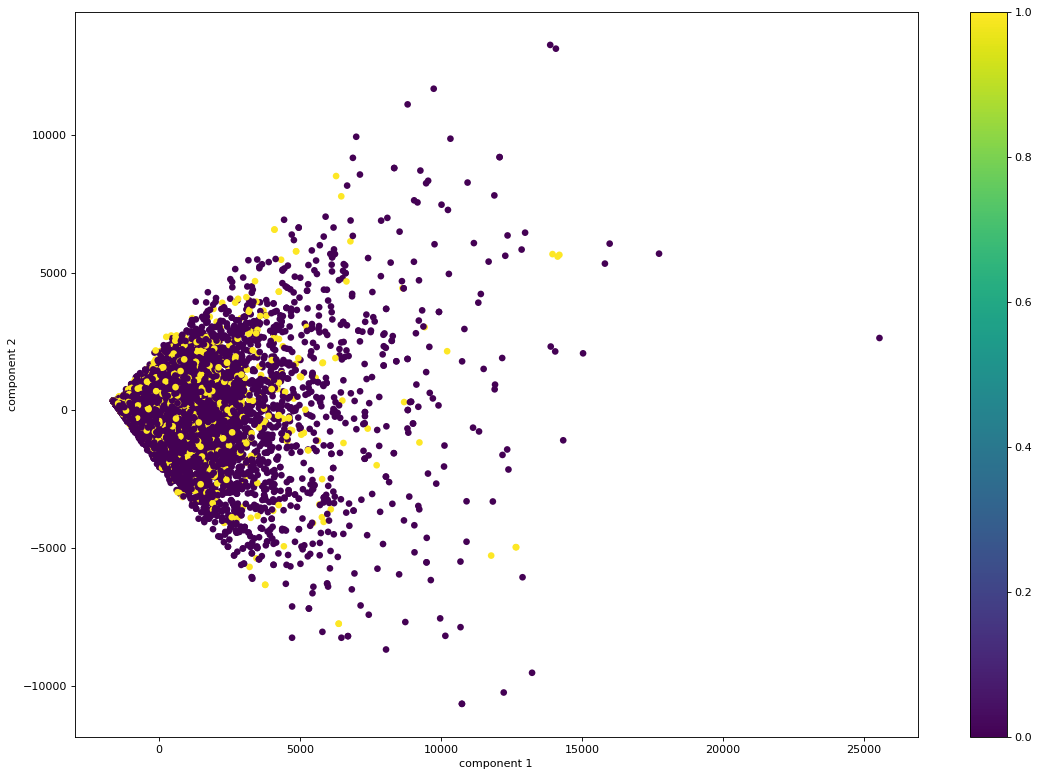

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

pca = PCA(2, svd_solver='full') 
projected = pca.fit_transform(pred_df[new_col_names])

plt.scatter(projected[:, 0], projected[:, 1],
            c=pred_df['prediction'], edgecolor='none')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### clustering experiment

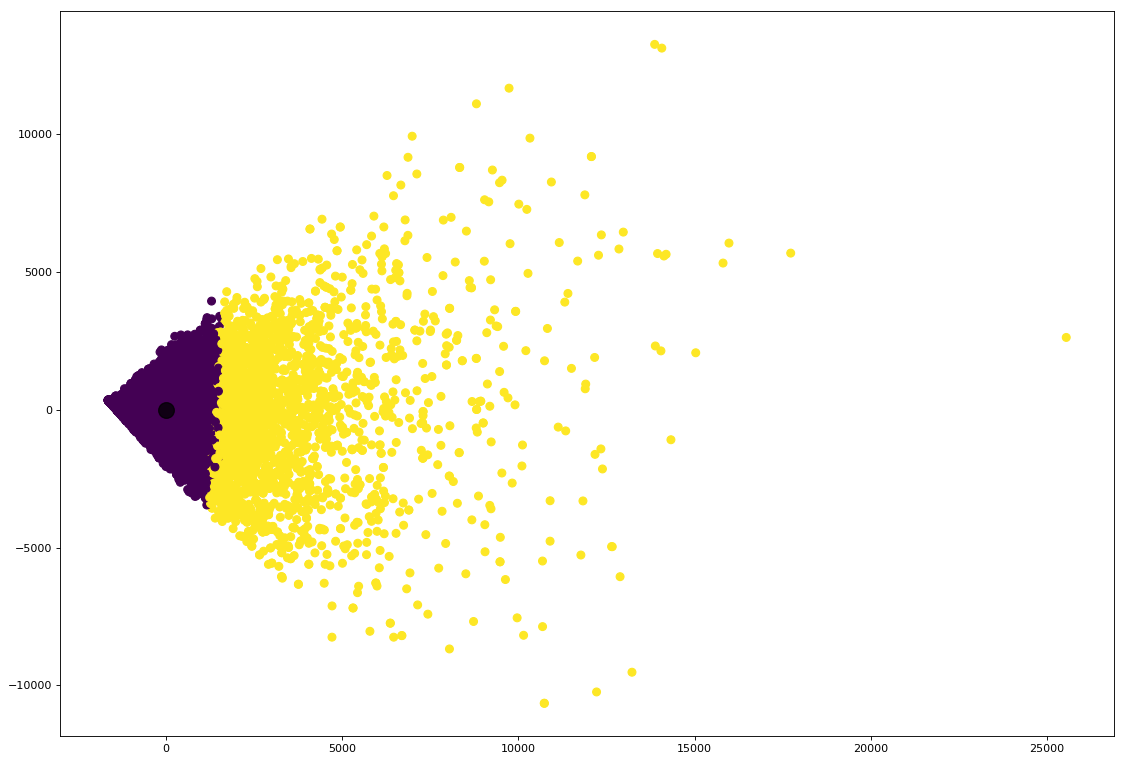

In [83]:
from sklearn.cluster import KMeans

figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=2) 
kmeans.fit(pred_df[new_col_names], pred_df['prediction'])
y_kmeans = kmeans.predict(pred_df[new_col_names], pred_df['prediction'])

plt.scatter(projected[:, 0], projected[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)



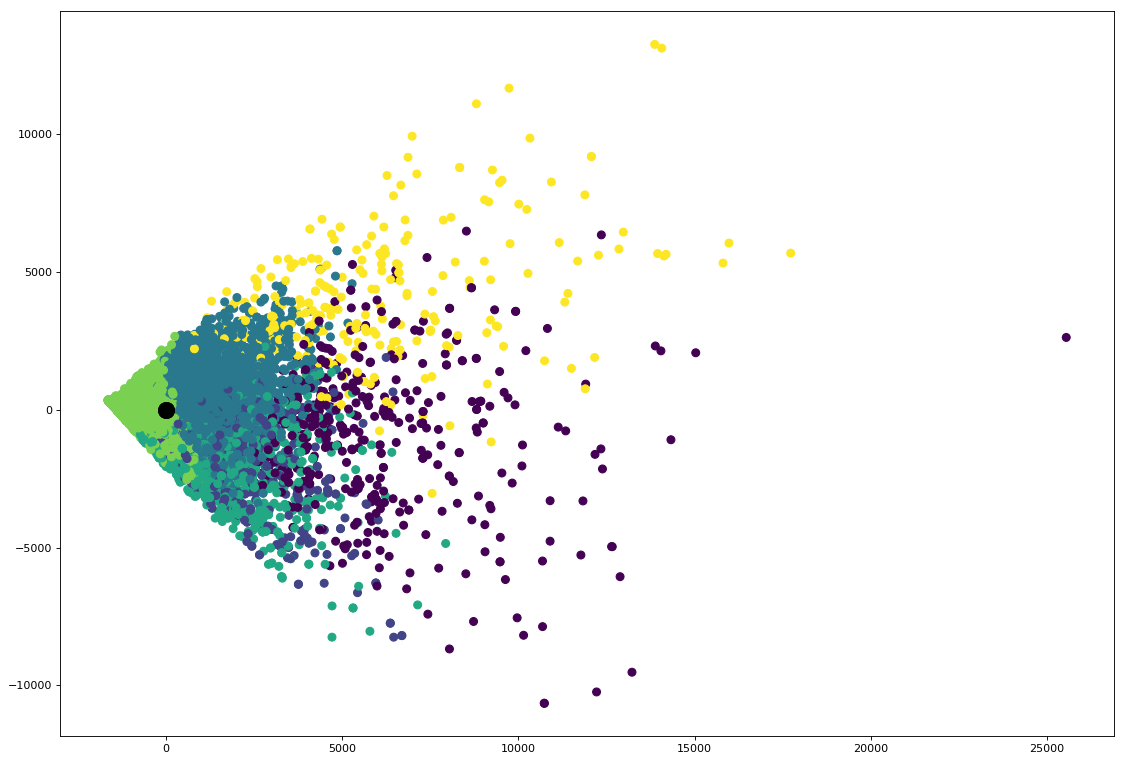

In [84]:
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=6) 
kmeans.fit(pred_df[new_col_names], pred_df['prediction'])
y_kmeans = kmeans.predict(pred_df[new_col_names], pred_df['prediction'])

plt.scatter(projected[:, 0], projected[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


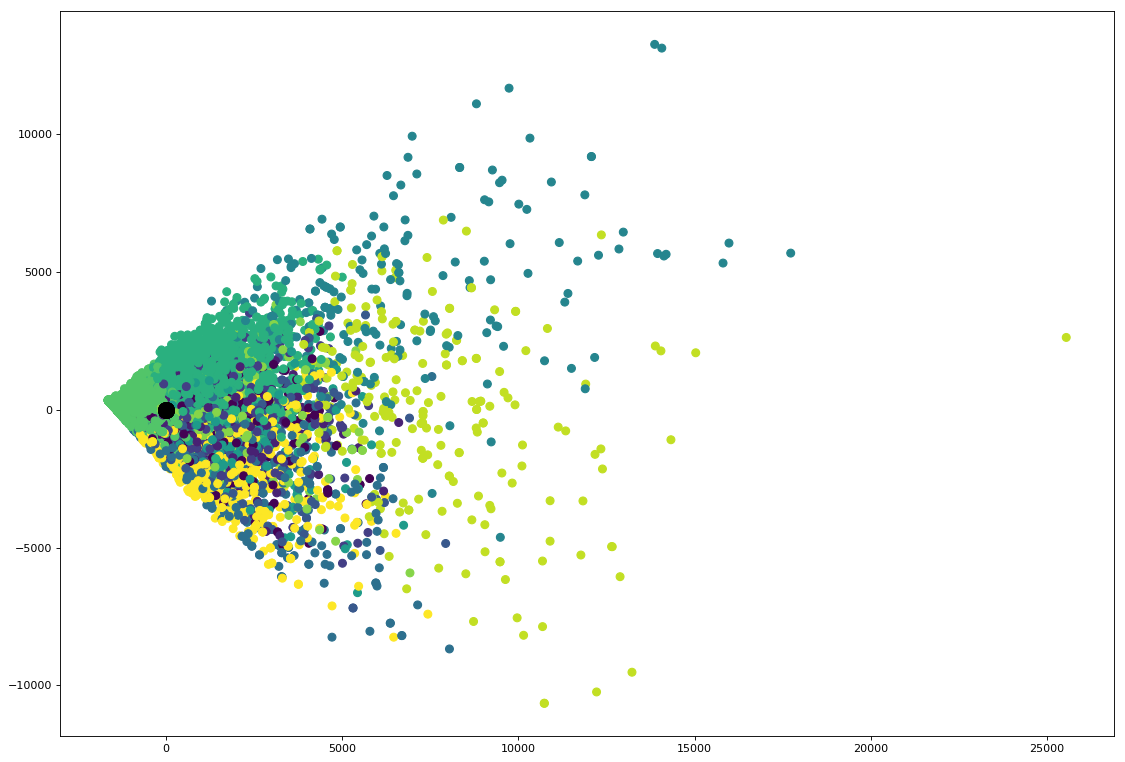

In [82]:
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=12) 
kmeans.fit(pred_df[new_col_names], pred_df['prediction'])
y_kmeans = kmeans.predict(pred_df[new_col_names], pred_df['prediction'])

plt.scatter(projected[:, 0], projected[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

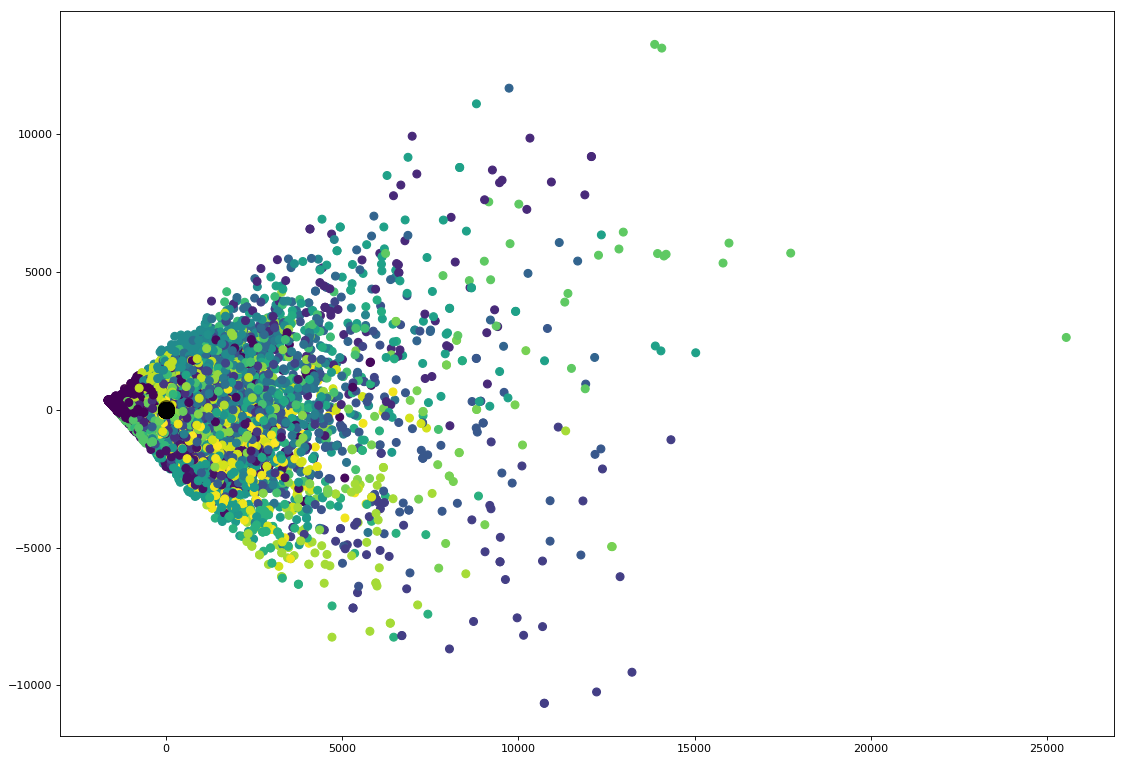

In [85]:
figure(num=None, figsize=(17, 12), dpi=80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=45) 
kmeans.fit(pred_df[new_col_names], pred_df['prediction'])
y_kmeans = kmeans.predict(pred_df[new_col_names], pred_df['prediction'])

plt.scatter(projected[:, 0], projected[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)